# Configuration du notebook

In [99]:
# Data analysis libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud

# Image processing library
from PIL import Image

# Text processing libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cramarokoto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
# Chargement des données
X_train = pd.read_csv("./../data/X_train_update.csv", index_col=0)
y_train = pd.read_csv("./../data/Y_train_CVw08PX.csv", index_col=0)
X_test = pd.read_csv("./../data/X_test_update.csv", index_col=0)

In [101]:
def data_info(df):
    df.info()
    print("\n")
    display(df.head())
    print("\n")


# Exploration des données

Les premières choses à comprendre concernant les données :

- X_train contient toutes les données que nous avons pour l'entraînement ET les tests : elles sont associées aux valeurs de y_train.
- X_test contient uniquement les données à classifier avec notre modèle afin d’être évalué dans le cadre du challenge Rakuten.
- Il en va de même pour les images.

## Description de X_train

In [102]:
data_info(X_train)

#### Nan values in X_train ####

print("NaN values in X_train")
X_train_nan = X_train.isna().sum()
print(X_train_nan)
print("\n")

print("Nan values ratio in X_train", X_train_nan / len(X_train))

#### Unique values in train variables ####

print("Unique value numbers in train variables :", end = "\n\n")
print(X_train.nunique(), end = "\n\n")

# Less unique values in Designation than productid and imageid -> Duplicates with different id ?

#### Duplicated values in train variables ####

print("# of duplicates in designation :", round(X_train.duplicated(subset = ["designation"]).sum()/len(X_train["designation"])*100, 2), "%")
print("# of duplicates in productid :", X_train.duplicated(subset = ["productid"]).sum())
print("# of duplicates in imageid :", X_train.duplicated(subset = ["imageid"]).sum())

# Duplicates of products with different productid and imageid

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB




designation  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                               La Guerre Des Tuques   

                                         description   productid     imageid  
0                                                NaN  3804725264  1263597046  
1                                                NaN   436067568  1008141237  
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978  
3                                                NaN    50418756   457047496  
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786



NaN values in X_train
designation        0
description    29800
productid          0
imageid            0
dtype: int64


Nan values ratio in X_train designation    0.000000
description    0.350935
productid      0.000000
imageid        0.000000
dtype: float64
Unique value numbers in train variables :

designation    82265
description    47506
productid      84916
imageid        84916
dtype: int64

# of duplicates in designation : 3.12 %
# of duplicates in productid : 0
# of duplicates in imageid : 0


Conformément à la description des données, seule la description est optionnelle, on remarque que le jeu de données est complet et que c'est la seule variable avec des valeurs nulles.

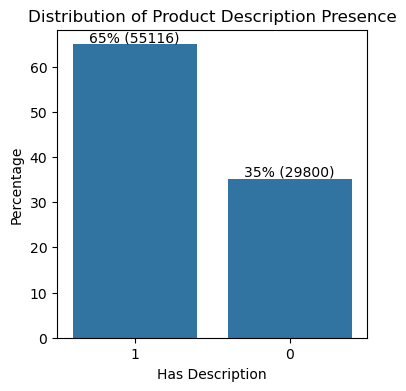

In [103]:
# Dichotomisation de la présence de description dans X_train
X_train['has_description'] = X_train['description'].notna().astype(int)

abs_values = X_train['has_description'].value_counts(ascending=False)
rel_values = X_train['has_description'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}% ({p[0]})' for p in zip(abs_values, rel_values)]

# Affichage de la distribution de has_description
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=X_train, x='has_description', order=X_train['has_description'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Description Presence')
plt.xlabel('Has Description')
plt.ylabel('Percentage')
plt.show()

Il y a plus de produits avec une description (65 %) que de produits sans description (35%) malgré le caractère optionnel de la description. On peut supposer que cela est dû à l'importance de la description de l'article pour favoriser sa vente en plus de sa catégorisation. En effet, la description fournit d'autres éléments discriminant pour un produit dans le cadre de la recherche via un moteur parmi de nombreux produits.

## Description de y_train

In [104]:
data_info(y_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB




prdtypecode
0           10
1         2280
2           50
3         1280
4         2705

In [105]:
# Nombre de valeurs uniques dans y_train
print("Unique values in y_train")
print(y_train.nunique())

Unique values in y_train
prdtypecode    27
dtype: int64


Il existe 27 classes de produits distinctes dans le jeu de données d'apprentissage.

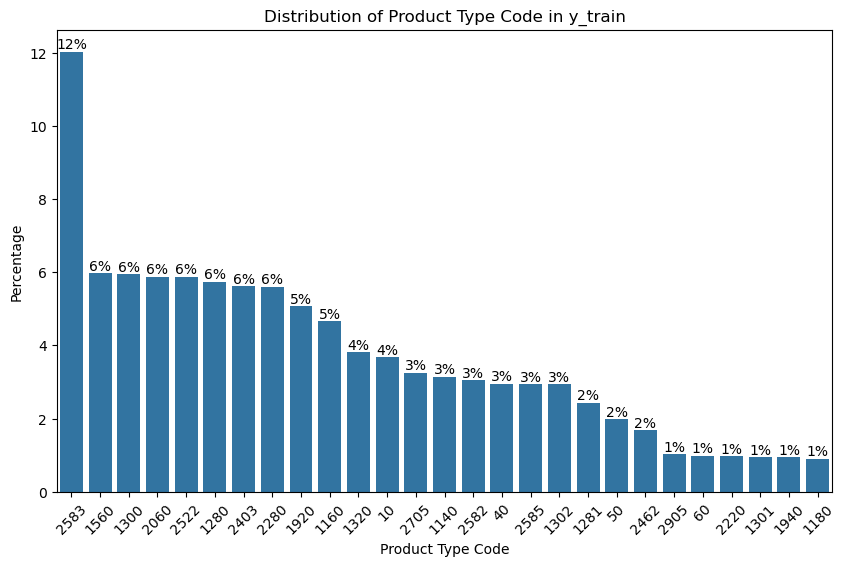

In [106]:
abs_values = y_train['prdtypecode'].value_counts(ascending=False)
rel_values = y_train['prdtypecode'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}%' for p in zip(abs_values, rel_values)]

# Histogramme de la distribution des codes de type de produit dans y_train
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=y_train, x='prdtypecode', order=y_train['prdtypecode'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Type Code in y_train')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

Le jeu de données n'est pas équilibré :
- la classe 2583 est plus représentée que les autres avec 12% du jeu de données
- les classes 1560, 1300, 2060, 2522, 1280, 2403, 2280 suivent ensuite avec 6% chacune seulement
- les classes les moins représentées (2905, 60, 2220, 1301, 1940, 1180) représentent quant à elles 1% chacune

## Analyse des variables disponibles

### Analyse croisée entre la présence de 'description' du produit et la catégorie du produit


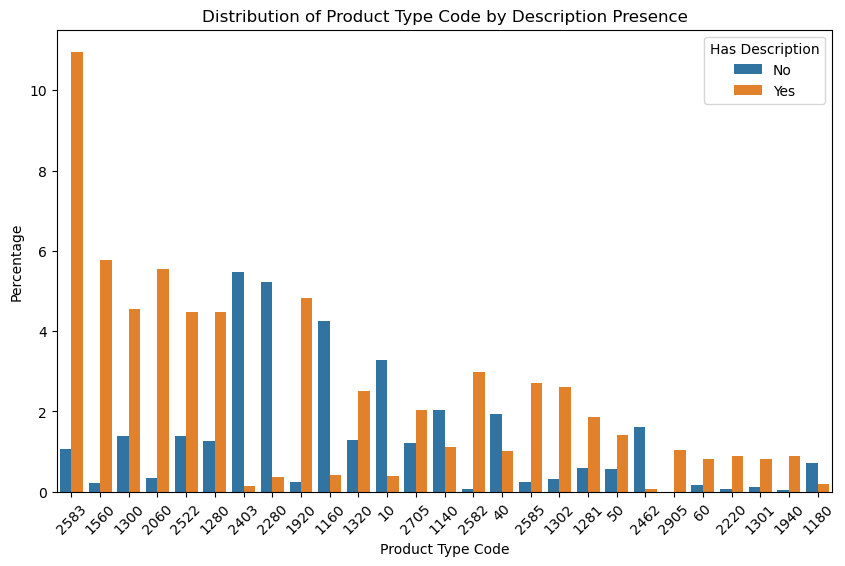

In [107]:
# Affichage de la distribution des codes de type de produit en fonction de la présence de description
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train, x='prdtypecode', hue=X_train['has_description'], order=y_train['prdtypecode'].value_counts().index, stat='percent')
plt.title('Distribution of Product Type Code by Description Presence')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Has Description', loc='upper right', labels=['No', 'Yes'])
plt.show()

La répartition de produits avec ou sans description n'est pas homogène entre les catégories de produit par rapport au ratio moyen du jeu de données (65% avec et 35% sans description).
Certains produits comme 2403 contiennent majoritairement des produits non décrits alors que d'autres comme 1560 contiennent majoritairement des produits décrits.

### Analyse de la longueur de la variable 'designation'


Text(0.5, 0, 'Designation Length')

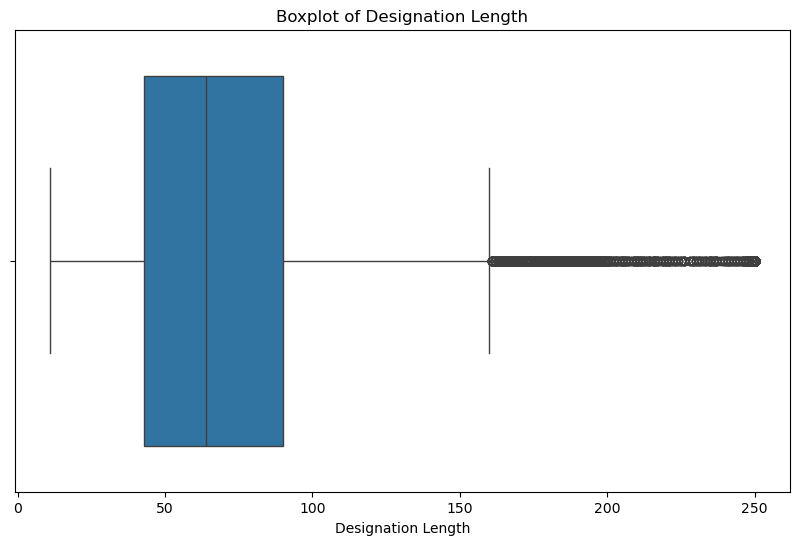

In [108]:
X_train['designation_length'] = X_train['designation'].str.len()

# Boxplot de la longueur de la variable 'designation'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='designation_length')

plt.title('Boxplot of Designation Length')
plt.xlabel('Designation Length')

In [109]:
X_train['designation_length'].describe()

count    84916.000000
mean        70.163303
std         36.793383
min         11.000000
25%         43.000000
50%         64.000000
75%         90.000000
max        250.000000
Name: designation_length, dtype: float64

On observe que la longueur de designation est très variable avec un min de 11 caractères et un max de 250 caractères.
Sa longueur moyenne est de 70 caractères et la médiane se situe à 64 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 160 caractères.

### Analyse croisée de la catégorie et de la longueur de la 'designation'

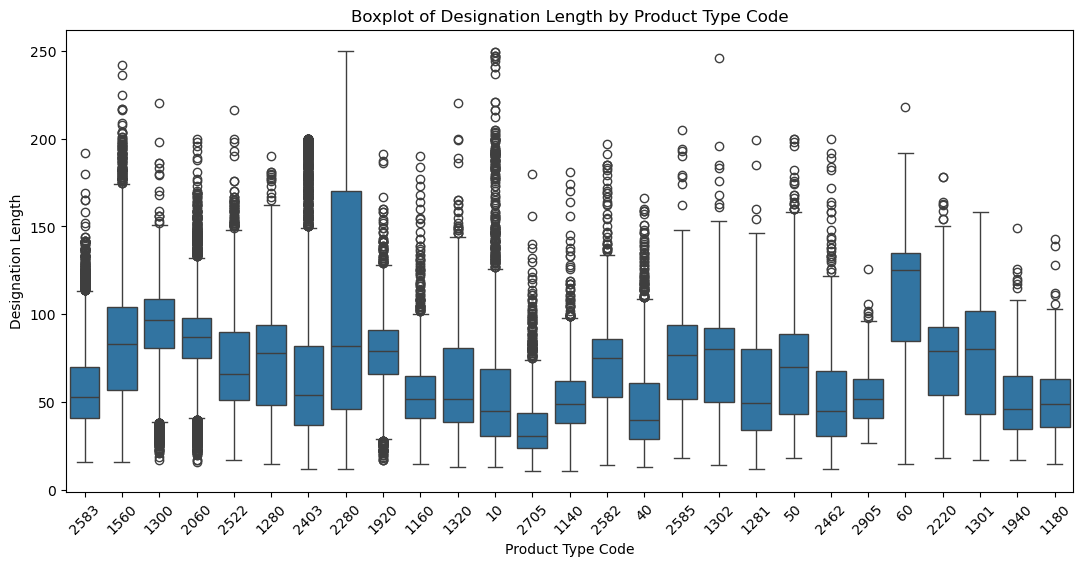

In [110]:
# Boxplot de la longueur de la variable 'designation' par catégorie de produit
plt.figure(figsize=(13, 6))
sns.boxplot(x=y_train['prdtypecode'], y=X_train['designation_length'], order=y_train['prdtypecode'].value_counts().index)
plt.title('Boxplot of Designation Length by Product Type Code')
plt.xlabel('Product Type Code')
plt.ylabel('Designation Length')
plt.xticks(rotation=45)
plt.show()

La distribution de la longueur de Designation par catégorie de produit n'est pas homogène.

### Analyse des duplicats de 'designation'

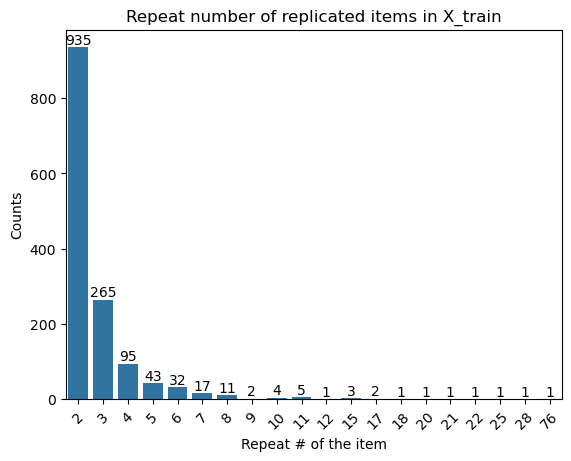

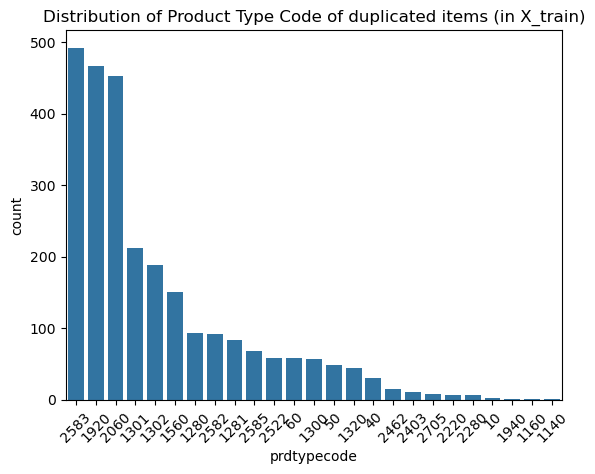

In [111]:
#### Duplicated values frequencies

counts = X_train["designation"].value_counts().reset_index()
counts.columns = ["designation", "repeat"]

repeats = counts['repeat'].value_counts().sort_index().reset_index()

repeats = repeats.iloc[1:]

ax = sns.barplot(data = repeats, x = 'index', y = 'repeat')
ax.bar_label(container = ax.containers[0],  fmt='%d')
plt.xticks(rotation = 45)
plt.xlabel("Repeat # of the item")
plt.ylabel("Counts")
plt.title("Repeat number of replicated items in X_train")
plt.show()


#### Duplicated values' categories

y_duplicated = y_train[X_train.duplicated(subset = ["designation"]) == True]

sns.countplot(data = y_duplicated, x = 'prdtypecode', order = y_duplicated['prdtypecode'].value_counts().index)
plt.xticks(rotation = 45)
plt.title("Distribution of Product Type Code of duplicated items (in X_train)")
plt.show()

On observe de récurrents lignes de 'Designation' avec des fréquences qui varient de 2 à 76 instances: 935 articles se répètent 2 fois, 1 article 76 fois
On observe ces répétitions de Designation dans des catégories différentes

### Analyse de la longueur de la variable 'description'


Text(0.5, 0, 'Description Length')

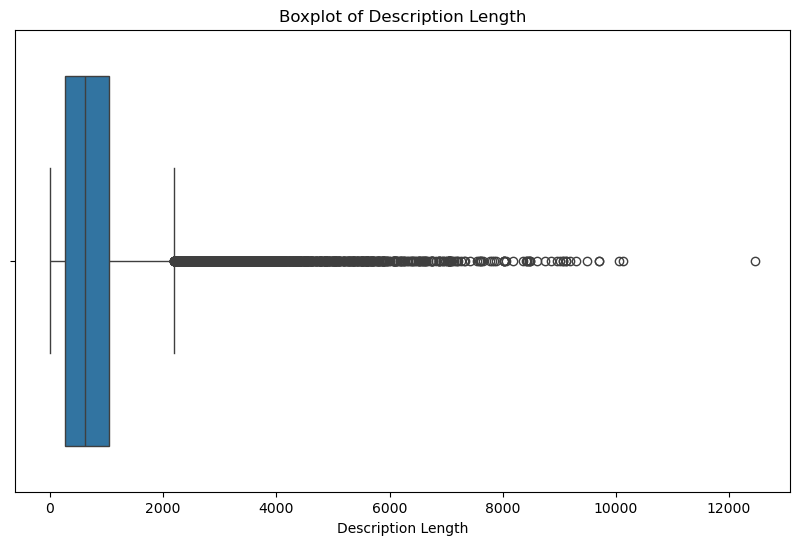

In [112]:
X_train['description_length'] = X_train['description'].str.len()

# Boxplot de la longueur de la variable 'descpription'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='description_length')

plt.title('Boxplot of Description Length')
plt.xlabel('Description Length')

In [113]:
X_train['description_length'].describe()

count    55116.000000
mean       808.171692
std        805.462153
min          1.000000
25%        259.000000
50%        626.000000
75%       1034.000000
max      12451.000000
Name: description_length, dtype: float64

On observe que la longueur de description est très variable avec un min de 1 caractères et un max de 12451 caractères.
Sa longueur moyenne est de 808 caractères et la médiane se situe à 626 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 2000 caractères.

### Analyse de la 'description' par catégorie de produit

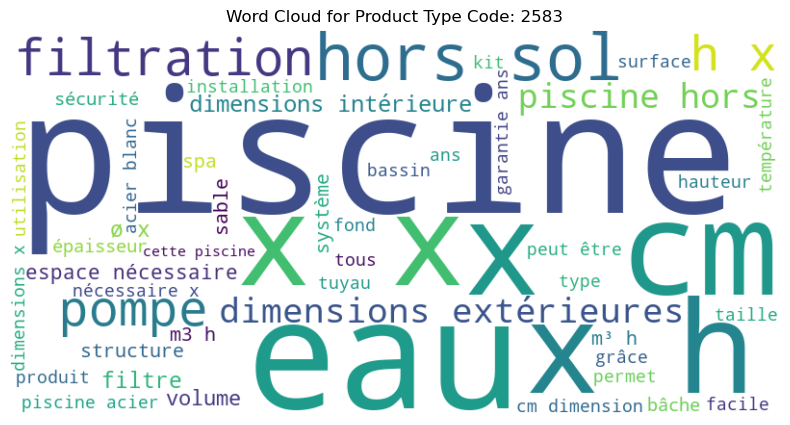

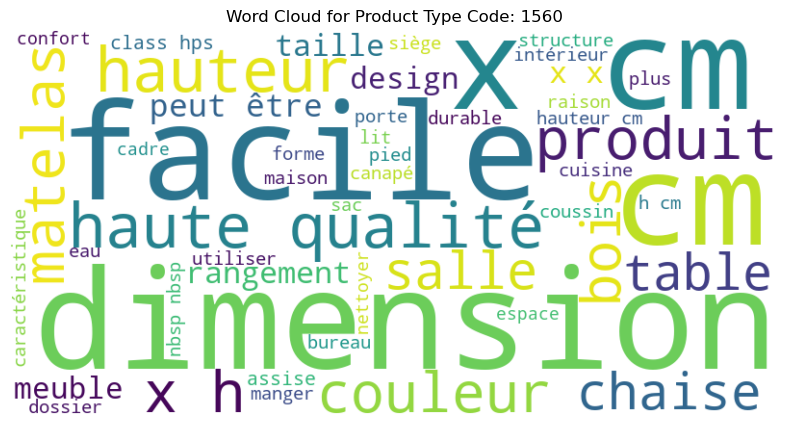

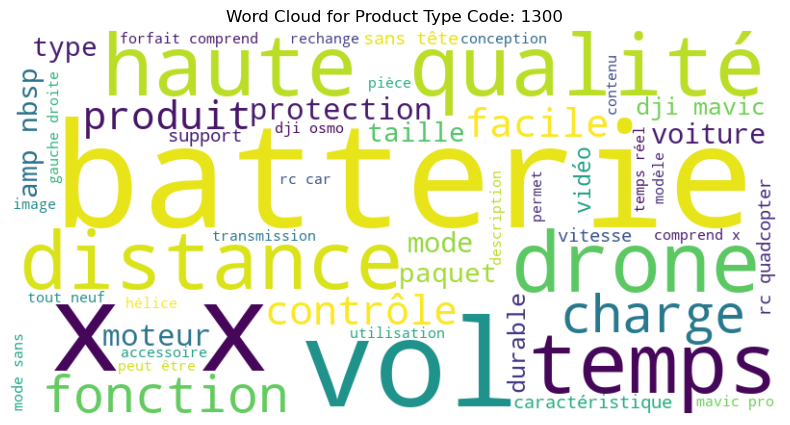

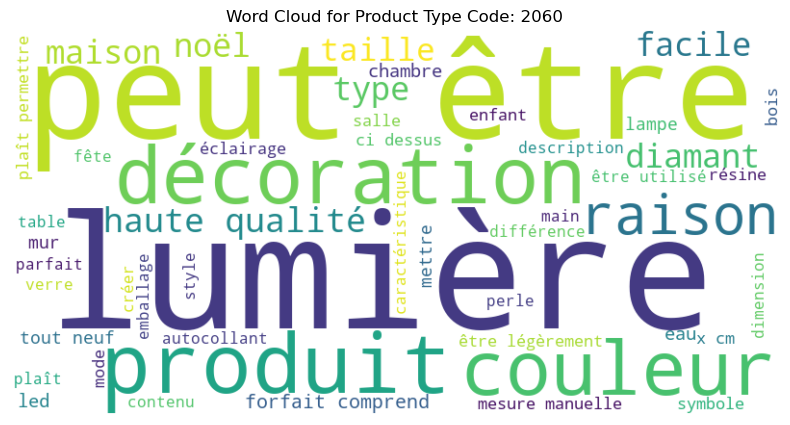

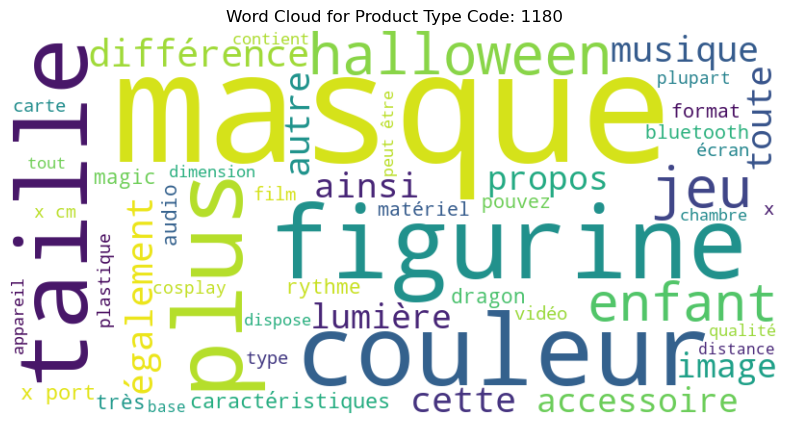

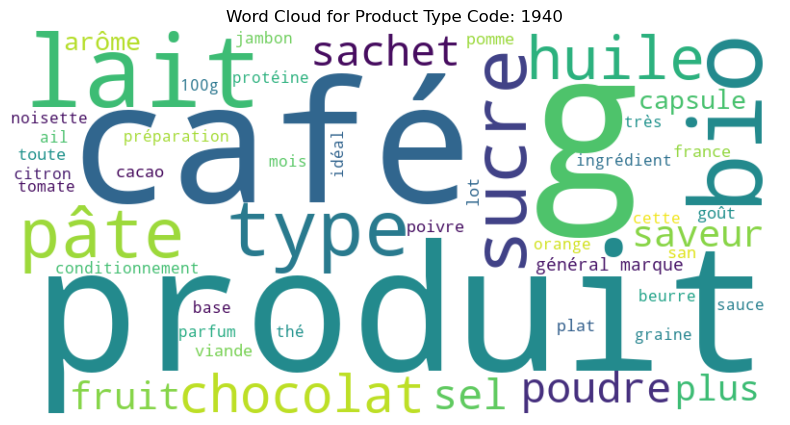

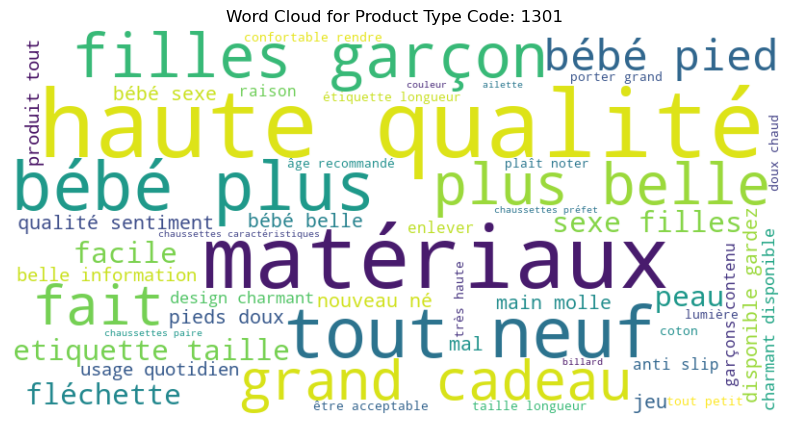

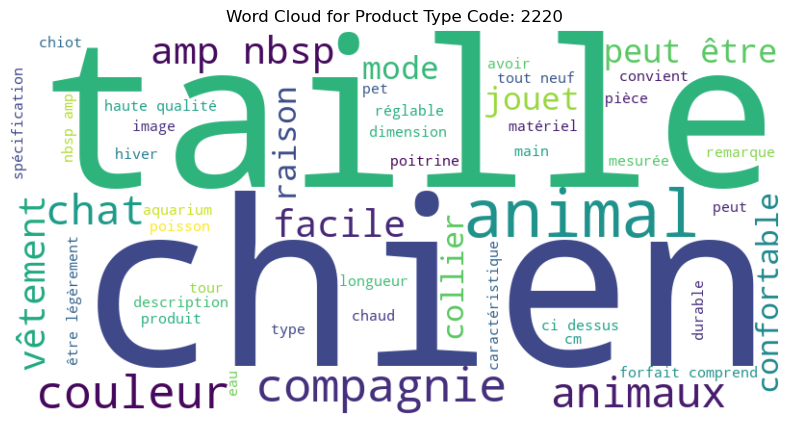

In [114]:
html_stopwords = ['br', 'p', 'div', 'span', 'b', 'i', 'li', 'ul', 'strong', 'em']
final_stopwords = stopwords.words('english') + stopwords.words('french') + html_stopwords

# Récupération des 4 catégories de produits avec le plus et le moins de descriptions pour comparaison
most_descriptions = y_train['prdtypecode'].value_counts().nlargest(4).index.tolist()
least_descriptions = y_train['prdtypecode'].value_counts().nsmallest(4).index.tolist()

# Concaténation de toutes les descriptions de chaque product code pour la création du nuage de mots
for code in most_descriptions + least_descriptions:
    text = ' '.join(X_train.loc[y_train['prdtypecode'] == code, 'description'].dropna().tolist())

    # Nettoyage du texte (apostrophes, ponctuation, etc.)
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Création du nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, stopwords = final_stopwords).generate(text)
    
    # Affichage du nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Product Type Code: {code}')
    plt.show()

Les 4 worclouds des catégories de produits avec le plus de descriptions et les 4 wordclouds de celles avec le moins de descriptions mettent clairement en avant certains termes plus que d'autres.

Cela nous permet d'identifier la catégorie de produit d'une manière sémantique à la lecture des termes mis en exergue : on pourra étudier cette intuition en faisant du deep learning ou encore du NLP pour classifier les catégories.

Sachant que nous avons principalement des données non structurées pour la classification (du texte parfois optionnel et des images), cette approche semble la plus efficace.

## Analyse des images

Chemins des dossiers d’images:

In [115]:
# Paths
image_train_path = "./../data/images/image_train/"
image_test_path = "./../data/images/image_test/"

### Affichage des images

Fonctions utiles pour l’affichage :

In [116]:
# Find a picture path from its imageid and its productid
def image_path(imageid, productid, split="train"):
    if split == "train":
        path = image_train_path
    elif split == "test":
        path = image_test_path
    else:
        raise Exception("split must be train or test.")

    image_path = path + "image_" + str(imageid) + "_product_" + str(productid) + ".jpg"
    return image_path


# Display an image from its path or an image objetc
def display_image(image, print_dim=False):
    if isinstance(image, str):
        img = mpimg.imread(image)
    else:
        img = image

    if print_dim:
        print(f"Image dimensions: {img.shape[0]}x{img.shape[1]} pixels")

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return


# Display an image from its imageid and its productid
def display_image_df(imageid, productid, split="train", print_dim=False):
    display_image(image_path(imageid, productid, split), print_dim)
    return


# Display an image from a textual row
def display_image_from_row(index_or_row_number, split="train", is_index=True, print_dim=False):
    """
    Display a picture from index (is_index must be True) or
    row number (is_index must be False) of the considered split.
    print_dim allows to print the dimensions of the image.
    """
    if split == "train":
        df = X_train
    elif split == "test":
        df = X_test
    else:
        raise Exception("split must be train or test.")
        
    if is_index:
        display_image_df(df.loc[index_or_row_number, "imageid"], df.loc[index_or_row_number, "productid"], split, print_dim)
    else:
        display_image_df(df.iloc[index_or_row_number, 3], df.iloc[index_or_row_number, 2], split, print_dim)
    return



Quelques exemples d'images avec les fonctions utiles vues précédemment.

Image dimensions: 500x500 pixels


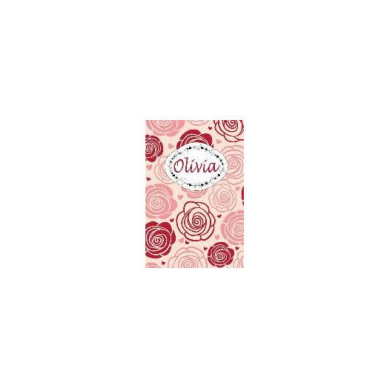

In [117]:
display_image_df(1263597046, 3804725264, "train", print_dim=True)

Image dimensions: 500x500 pixels


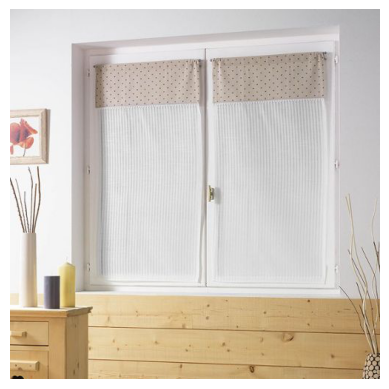

In [118]:
display_image_df(X_train.loc[13, "imageid"], X_train.loc[13, "productid"], "train", print_dim=True)

Image dimensions: 500x500 pixels


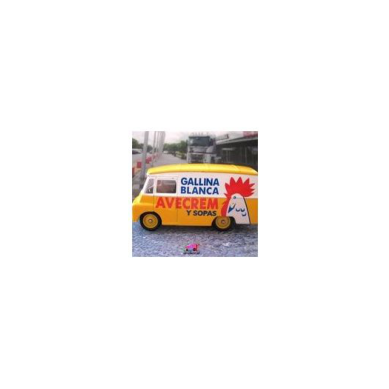

In [119]:
display_image_from_row(15, "test", is_index=False, print_dim=True)

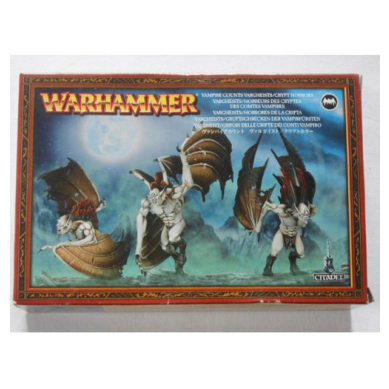

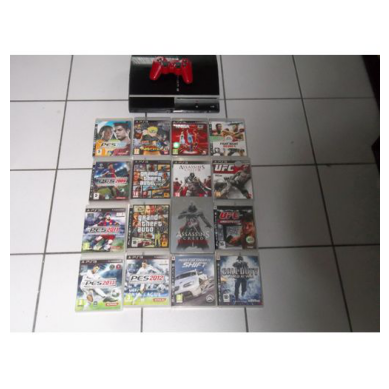

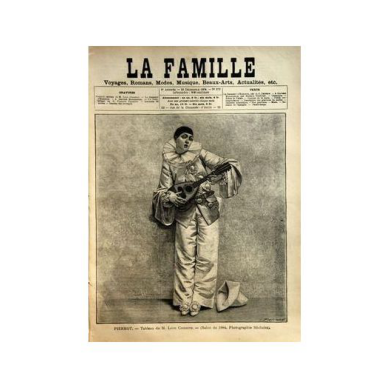

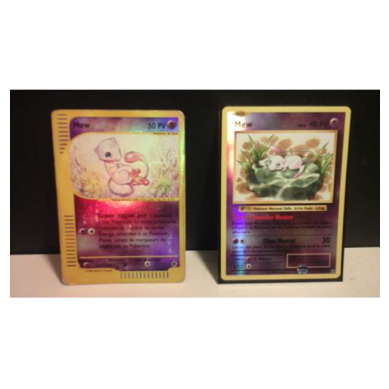

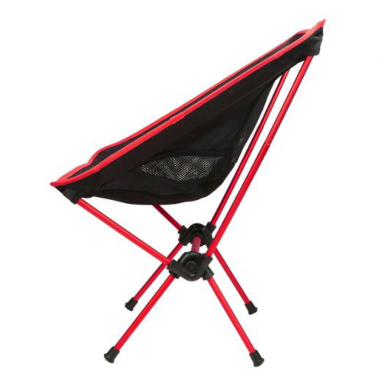

In [120]:
### Random images read with Matplotlib ###
for i in np.random.choice(np.arange(0, len(X_train)), size=5):
    display_image_from_row(i, "train", is_index=False)

On remarque que toutes les images semblent être de la même dimension 500x500 pixels et en couleur. Cependant leurs dimensions utiles sont différentes: la différence est comblée par des bords blancs.

Dans un premier temps, nous vérifierons l'unicité du format des images, puis nous nous intéresserons aux dimensions utiles.

### Affichage de l'image et de la description d'un produit par classe

Product type code: 10
Designation: Paris Enleve Le Roi.Octobre.1789 Paris Enleve Le Roi.Octobre.1789
Description: nan
Image dimensions: 500x500 pixels


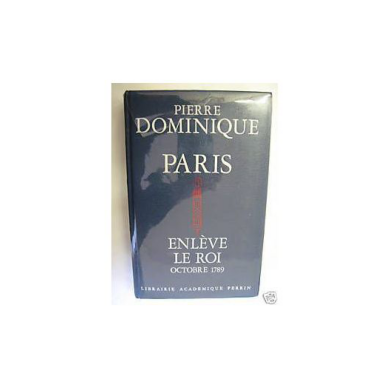

Product type code: 40
Designation: Grand Theft Auto V Xbox 360
Description: nan
Image dimensions: 500x500 pixels


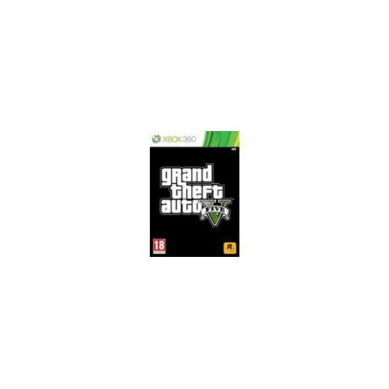

Product type code: 50
Designation: Edition Collector Artbook Tomb Raider Reborn
Description: Artbook de 32 pages.<BR>10x18cm.
Image dimensions: 500x500 pixels


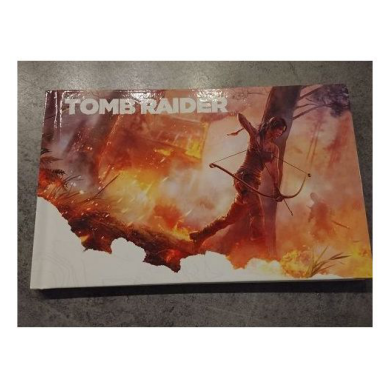

Product type code: 60
Designation: Pack Xbox 360 Slim 250 Go - Gta V Exclusif
Description: Pack Xbox 360 - 250 Go avec le jeu GTA V
Image dimensions: 500x500 pixels


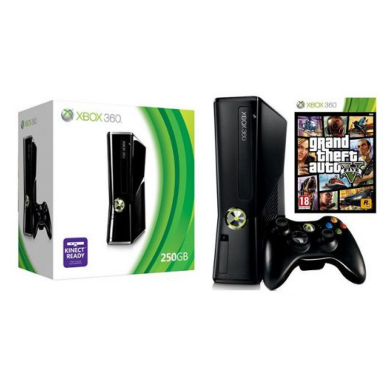

Product type code: 1140
Designation: Figurine Joe Bar Team Edouard Bracame Honda Cb 750 En Resine 1/18
Description: nan
Image dimensions: 500x500 pixels


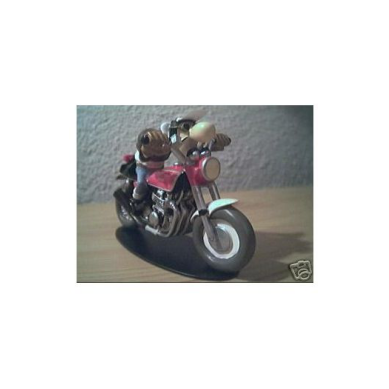

Product type code: 1160
Designation: Naruto Collectible Card Game Naruto Uzumaki R52/85
Description: nan
Image dimensions: 500x500 pixels


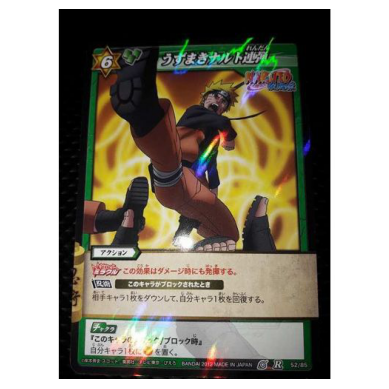

Product type code: 1180
Designation: Sw Miniatures - Champions Of The Force - 18/60 - Sith Trooper Commander
Description: nan
Image dimensions: 500x500 pixels


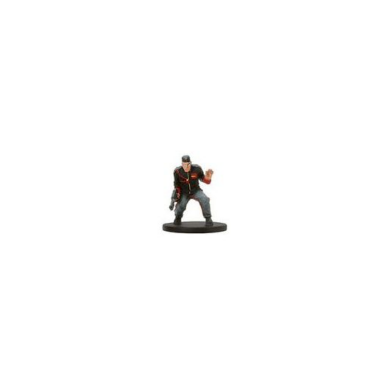

Product type code: 1280
Designation: Peluche Vache Musicale Les Jolis Pas Beaux Moulin Roty
Description: Cette magnifique bo&icircte musicale vache en peluche jolis pas beaux Moulin Roty avec ses couleurs parme et prune fera le bonheur de votre b&eacuteb&eacute !<br />&nbsp<br />D&eacutes la naissance.&nbsp<br />Mati&egravere : tissus et velours.<br />Dimensions: 15cm.
Image dimensions: 500x500 pixels


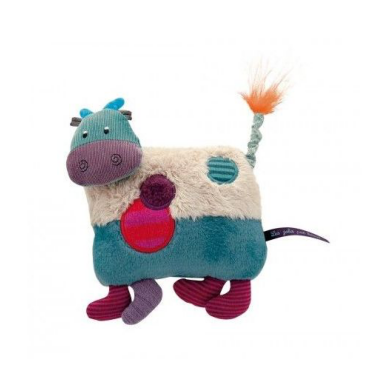

Product type code: 1281
Designation: Kings & Things (Jeu Stratégie 1986)
Description: Fantasy Boardgame en anglais de Games Workshop. Edition originale de 1986.
Image dimensions: 500x500 pixels


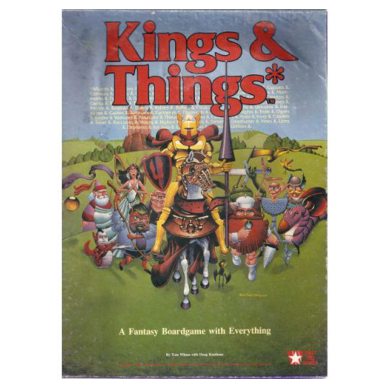

Product type code: 1300
Designation: Pour Dji 2 Zoom Drone Mavic Nd32 Filtres Objectif De La Caméra Étanche Scy80831101f-Générique
Description: Pour DJI 2 Zoom Drone Mavic nd32 Filtres objectif de la caméra étanche Caractéristiques: spécialement conçue pour DJI Zoom Drone caméra Mavic FPV. étanche à l&#39;eau efficace &amp; amp; la performance anti-rayures (multi-couches de film de revêtement). Poids léger composant logiciel enfichable sur la conception n&#39;affectera pas l&#39;auto-inspection de la caméra. Compatible avec: DJI MavicZoom Drone Filtre de densité neutre (nd32) Idéal pour les portraits et les scènes en plein air en plein soleil. Réduit la quantité de lumière atteignant le film sans affecter la couleur. Applique la vitesse d&#39;obturation lente sous une forte exposition au soleil. Permet des ouvertures plus larges la profondeur diminuant effectivement de champ. ND4 réduit l&#39;intensité de deux degrés; ND8 réduit trois ... Fait de verre optique de haute qualité. Le forf

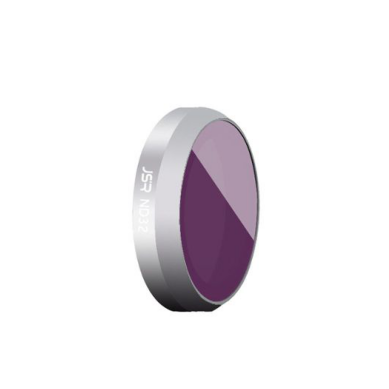

Product type code: 1301
Designation: Bumpers à vis (10)-Suprême
Description: nan
Image dimensions: 500x500 pixels


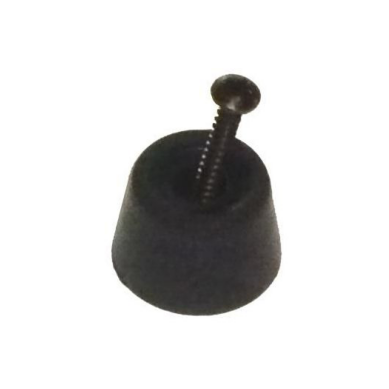

Product type code: 1302
Designation: Squishies Kawaii Hamburger De Sésame Jumbo Lente Hausse Crème Parfumée Stress Bt015
Description: Kawaii adorable Squishies Hamburger de sésame Jumbo lente hausse crème parfumée Stress Relief Description de jouets: Comme un jouet de décompression détendez-vous des jouets des articles de fête et enfants cadeaux de Noël cadeaux de halloween articles de fête bains pour bébés bain jouets jouets alimentaires de cuisine pour les enfants??. Quand vous regardez ils sont si mignons que vous pouvez vous sentir mieux ou même tous vos mauvais sentiments seront gone.It peut être un remède contre le stress. charme éponge est vraiment tactile confortable regard réaliste odorante et super mignons et kawaii charme doux pour téléphones mobiles sacs clés cadeaux collecte et plus encore! Aussi comme des jouets de soulagement du stress pour donner libre cours à vos émotions. Vous ne serez pas en mesure de garder vos mains sur ces Squishies montantes stupides super doux e

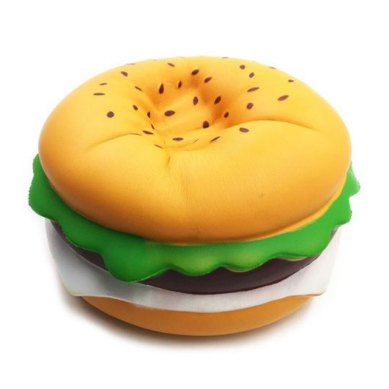

Product type code: 1320
Designation: Lässig - Lmbsu664 - Sac À Langer - Green Label - Small Messenger Bag Update - Denim Blue - Nouveau Dessin
Description: nan
Image dimensions: 500x500 pixels


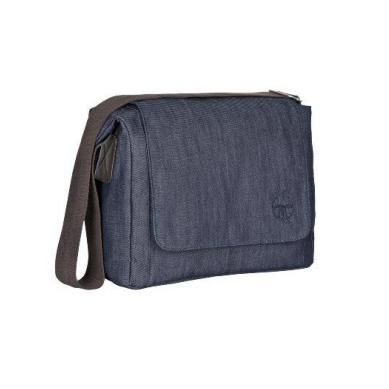

Product type code: 1560
Designation: Air Conditioning Universal Wind Deflector Cover Anti Direct Blowing Windshieldhpp6983
Description: Air Conditioning Universal Wind Deflector Cover Anti Direct Blowing WindshieldDescription :Name: Air-conditioning air deflector Scope of application: 1.5 horses - 3 horsesMaterial: PP&#43;PS&#43;PVC High-quality materialEasy to clean and easy to use Installation does not require punchingWith lock rope for easy fixingThe installation is simple easy to adjust beautifulFreely adjust the angle of the wind deflector change the wind direction through the wind deflector avoid direct blow to the bodyPacking:1x Wind Deflector
Image dimensions: 500x500 pixels


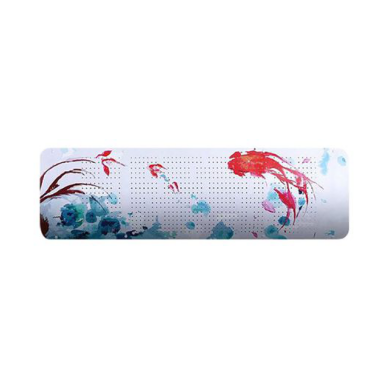

Product type code: 1920
Designation: 2pc Taie Sofa Taille Coussin Throw Cover Home Décor
Description: 2PC Taie Sofa taille coussin Throw Cover Home Decor points de vente des produits: Facile à changer fermeture à glissière invisible super lisse pour faciliter l&#39;insertion et le lavage. Fermeture à glissière invisible peut être ouvert autour 32-34cm pour l&#39;insertion de coussin. Mesures: 16x16inch sur mesure pour l&#39;insertion 16x16inch. Machine à laver séparément à doucement cycle seulement sans javellisant Séchage en machine LowPut notre housse de coussin sur votre canapé il est assez doux pour se reposer confortablement sur eux tout en regardant TV.Use cette housse de coussin pour protéger votre enfant lors de la lecture sur le sol. Matériel: Avis Plush: S&#39;il vous plaît permettre erreur 1-2cm en raison de la mesure manuelle. Pls assurez-vous que vous ne me dérange pas avant que vous offriez. Les couleurs peuvent avoir différentes que l&#39;affichage de différence pls comp

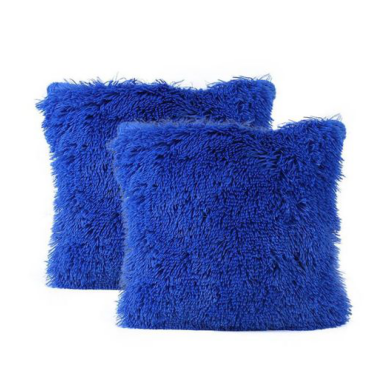

Product type code: 1940
Designation: Eric Bur Mini Croquants Aux Amandes. Tomates Et Piment D'espelette Aop - 75 G
Description: ERIC BUR Mini Croquants aux Amandes. Tomates et Piment d&#39;Espelette AOP - 75 g<br />ERIC BUR Mini Croquants aux Amandes Tomates et Piment d&#39;Espelette AOP - 75 g.
Image dimensions: 500x500 pixels


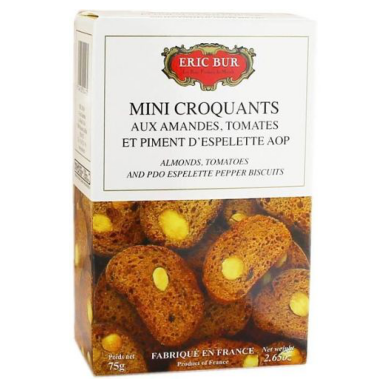

Product type code: 2060
Designation: Thème Le Jour De Pâques Vinyle Photographie Toile De Fond Props Contexte Photo Faite Sur Commande _Dw753
Description: Thème le jour de Pâques Photographie Vinyle Toile de fond personnalisée arrière-plan Photo Props Caractéristiques: Photographie Contexte: L&#39;utilisation d&#39;une série d&#39;équipements de production numérique de haute technologie soigneusement en jet d&#39;encre photos numériques images l&#39;image est claire réaliste adapté aux appareils photo numériques des matériaux de haute qualité en tissu fond numérique avec une couleur vive des motifs riches réaliste. forte usure durable clair non-éblouissement etc .. Matériel: tissu (Tissu vinyle) Stockage Léger facile et transporter; Pour la photographie les parties bars etc: fidélité couleur imperméable à l&#39;eau effec artistique Taille: 150 * 90cm Note: Pour faciliter le transport et l&#39;emballage sera plié expéditions de fond de tissu ce qui froissé; Ne vous inquiétez pas ne port

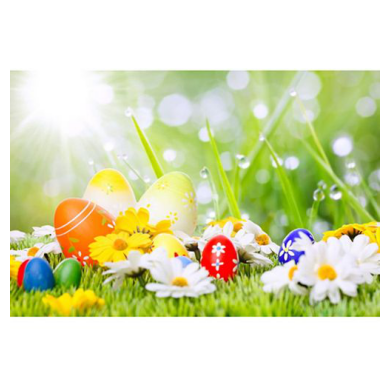

Product type code: 2220
Designation: Mangeoire À Graines Trèfle
Description: <b><u>Aspect : </u></b><u><br />Matériau principal : Bois<br />Matériaux secondaires : Anneau métallique Couverture de toit en inox brossé Paroi en plexiglas <br />Motif : Trèfle<br /><b><u>Dimensions : </u></b></u><u><br />Hauteur (en cm) : 2800<br />Longueur (en cm) : 1600<br />Profondeur (en cm) : 1400<br /><b><u>Autres caractéristiques : </u></b></u><u><br />Collection : Lucky Garden<br />Installation : A suspendre<br />Livré en kit : Oui<br />Poids (en kg) : 045<br /><br /><br /> <br /><br /> Mangeoire à graines <br />Trèfle<br />A suspendre</u>
Image dimensions: 500x500 pixels


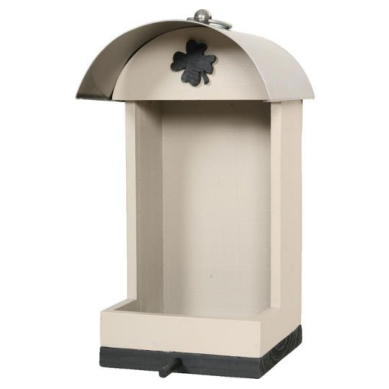

Product type code: 2280
Designation: Les Belles Histoires 474 :La Petite Fille Qui Botta Les Fesses D'une Montagne
Description: nan
Image dimensions: 500x500 pixels


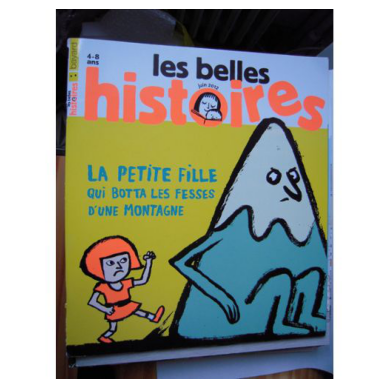

Product type code: 2403
Designation: Zettai Karen Children 6 7 8 9 10 Shiina Kana
Description: nan
Image dimensions: 500x500 pixels


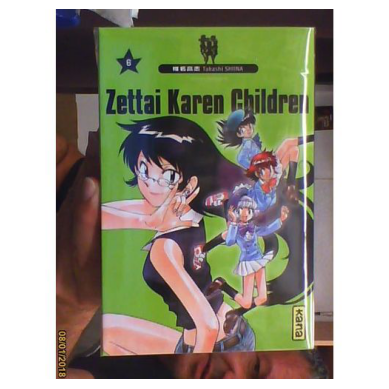

Product type code: 2462
Designation: Lot - Triple Pack - Trials Hd - Limbo - Splosion Man - Sur Microsoft Xbox 360 - Xbox360 + 1 Jeu Pc Neuf (Voir Photos)
Description: nan
Image dimensions: 500x500 pixels


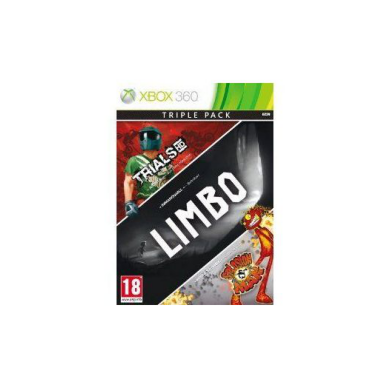

Product type code: 2522
Designation: Carnet De Notes Bloc-Notes Cahiersymbole Carre Jaune - Noir Personne Handicapee Les Carnets De Travail Classique Sur Support Papier Cadeau Tissu
Description: Taille: En format A5 (144 cm x 21 cm) Caract?istique: -Excellente durabilit?avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit?  ?rire facilement sur et assez ?aisse.
Image dimensions: 500x500 pixels


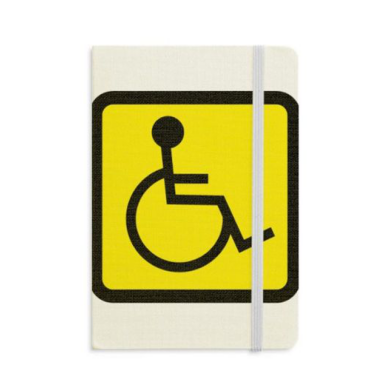

Product type code: 2582
Designation: Bain Oiseaux Mangeoire A Oiseau Abreuvoir Jardinière Porte Plante Vide Poche En Fonte Patinée Marron 11x12x44cm
Description: <div> <div> <p>Ce bac à fleurs de forme<strong> ovale</strong> est surmonté par deux oiseaux l&#39;un <strong>aux ailes déployées</strong> l&#39;autre<strong> aux ailes fermées. </strong>Ce bain d&#39;oiseau dispose également de deux poignées pour une facilité de déplacement.</p> <p>Habillez vos <strong>bords de fenêtres votre balcon ou votre terrasse</strong> avec cette jardinière en fonte patiné marron à l&#39;ancienne.</p> <p>Ce bac ancien ou bénitier accueillera avec beaucoup de<strong> charme et d&#39;élégance </strong>vos plus belles plantes et vos magnifiques fleurs qu&#39;elles soient d&#39;intérieur ou d&#39;extérieur mais également l&#39;eau et les graines de vos oiseaux. Ce pot de fleurs s&#39;intégrera très bien dans des ambiances <strong>brocante ou jardin d&#39;Eden.</strong></p> <p>Vous aurez la possibilité de l

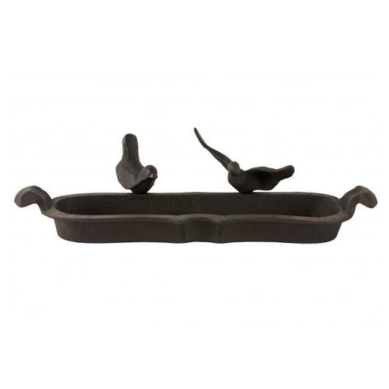

Product type code: 2583
Designation: Tapis chauffant solaire PVC 12 x 12 m 2 pcs Noir
Description: <p>L&#39;ensemble de deux tapis chauffants solaires d&#39;Intex pr¿sente un moyen efficace ¿nerg¿tiquement de chauffer votre piscine hors-sol en capturant les rayons du soleil. Il int¿gre une technologie solaire ¿cologique dans la surface du tapis pour absorber les rayons du soleil augmentant la temp¿rature de l&#39;eau de la piscine par environ 3ø - 5ø C (5ø - 9ø F) selon les conditions m¿t¿orologiques. Construit en PVC robuste stabilis¿ aux UV ce tapis convient parfaitement ¿ l&#39;usage ext¿rieur. Il est livr¿ avec tous les accessoires y compris les points de fixation du tuyau et un tuyau de 05 m pour un raccordement facile un adaptateur A et B pour les tuyaux de 38 mm de diam¿tre et une vanne de d¿rivation. Simple ¿ suspendre les tapis sont compatibles avec des pompes ¿ filtre de jusqu&#39;¿ 1/3 chevaux ou des pompes avec un d¿bit inf¿rieur ¿ 7 570 L par heure. La livraison comprend 2

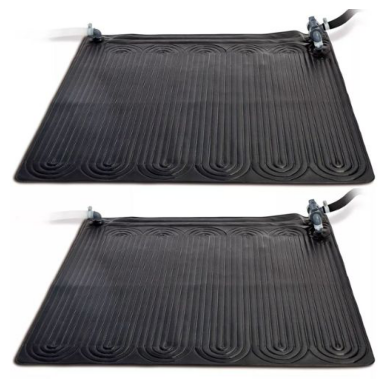

Product type code: 2585
Designation: Bosch-Scie trépan diamantée 6 mm pour GTR 30 CE
Description: Description<br/><br/>Poids : 90 g<br/>Longueur : 50 mm<br/>Largeur : 130 mm<br/>Hauteur : 45 mm<br/>Diamètre : 6 mm<br/>Couleur : Gris<br/>Type d'utilisation : Intensive / Professionnelle
Image dimensions: 500x500 pixels


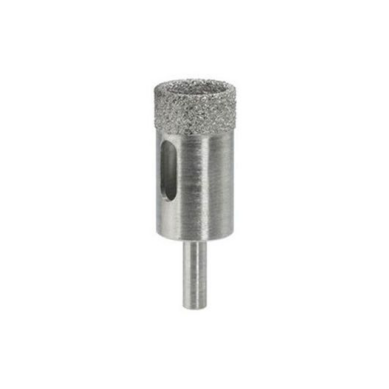

Product type code: 2705
Designation: Jules Renard ; Ses Oeuvres - 22 Titres
Description: nan
Image dimensions: 500x500 pixels


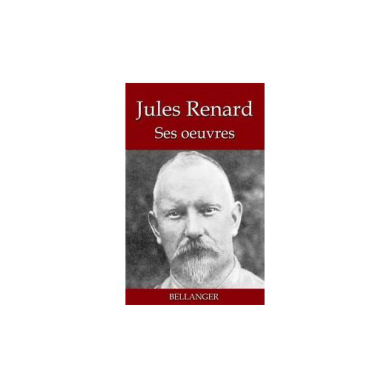

Product type code: 2905
Designation: Carribean Riddle - Jeu En Téléchargement
Description: <p>En plus d&#39;assembler des pierres précieuses des joyaux et des pièces tout en voyageant dans les Caraïbes vous relâcherez des poissons prisonniers pour gagner de nouveaux pouvoirs chasserez des méchants pirates et trouverez un trésor englouti. Vous profiterez également d&#39;une histoire réconfortante sur le thème de l&#39;amour triomphant de tous les obstacles. </p> <p>Caribbean Riddle dispose de graphismes superbes d&#39;une musique et de sons originaux de mini-jeux prenants et d&#39;un monde sous-marin réaliste peuplé d&#39;une faune aquatique en 3D. Alors laissez de coté vos soucis du quotidien et plongez dans les eaux fraîches de Caribbean Riddle. Vous n&#39;avez besoin que de votre imagination !</p><p>Points forts de Carribean Riddle</p><ul><li>50 niveaux </li><li>Des fonds animés en 3D </li><li>Des améliorations gratuites vers les nouvelles versions</li></ul>
Image dimensions: 500x500

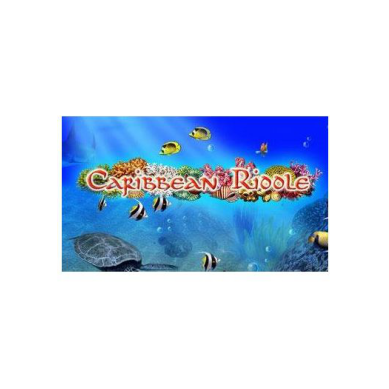

In [121]:
# Random selection of one index in y_train for each type of product code
random_indices = y_train.groupby('prdtypecode').apply(lambda x: x.sample(1)).index.get_level_values(1).tolist()

# Display the image for the randomly selected indices
for idx in random_indices:
    print(f"Product type code: {y_train.loc[idx, 'prdtypecode']}")
    print(f"Designation: {X_train.loc[idx, 'designation']}")
    print(f"Description: {X_train.loc[idx, 'description']}")

    display_image_from_row(idx, "train", is_index=True, print_dim=True)

### Vérification du format

Associons à chaque produit le path de l'image qui lui correspond.

In [122]:
X_train["imagepath"] = X_train.apply(lambda row: image_path(row["imageid"], row["productid"], "train"), axis=1)
X_test["imagepath"] = X_test.apply(lambda row: image_path(row["imageid"], row["productid"], "test"), axis=1)

Le dataset traincontient autant que d'images que de produits (84916). On pose alors l'hypothèse très probable que chaque produit a bien une image associée, même si elle est vide (entièrement blanche, ce qu'on testera plus tard), ce qui correspondrait à une valeur nulle.

Les chargements ou traitements d'image étant assez lourds, nous décidons de prendre seulement un échantillon de 1000 images aléatoires (mais reproductible) pour notre première analyse, et nous gardons les produits associées en textuel de côté.

In [123]:
X_train_sample = X_train.sample(n=1000, random_state=42)

X_img_sample = X_train_sample["imagepath"]
X_img_sample.head()

36138    ./../data/images/image_train/image_1100082580_...
68630    ./../data/images/image_train/image_1139624392_...
36172    ./../data/images/image_train/image_1271697301_...
9830     ./../data/images/image_train/image_1313204688_...
28422    ./../data/images/image_train/image_518749844_p...
Name: imagepath, dtype: object

On l'enrichit avec d'autres informations.

In [124]:
def shape_from_path(image_path):
    img = mpimg.imread(image_path)
    return img.shape

In [125]:
X_img_sample = pd.concat([
    X_img_sample.rename("image_path"),
    X_img_sample.apply(shape_from_path).rename("image_shape")
], axis=1)

In [126]:
data_info(X_img_sample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 36138 to 65534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   1000 non-null   object
 1   image_shape  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB




image_path    image_shape
36138  ./../data/images/image_train/image_1100082580_...  (500, 500, 3)
68630  ./../data/images/image_train/image_1139624392_...  (500, 500, 3)
36172  ./../data/images/image_train/image_1271697301_...  (500, 500, 3)
9830   ./../data/images/image_train/image_1313204688_...  (500, 500, 3)
28422  ./../data/images/image_train/image_518749844_p...  (500, 500, 3)

Vérifions que dans le dataset (au moins dans l'échantillon), toutes les images sont au même format.

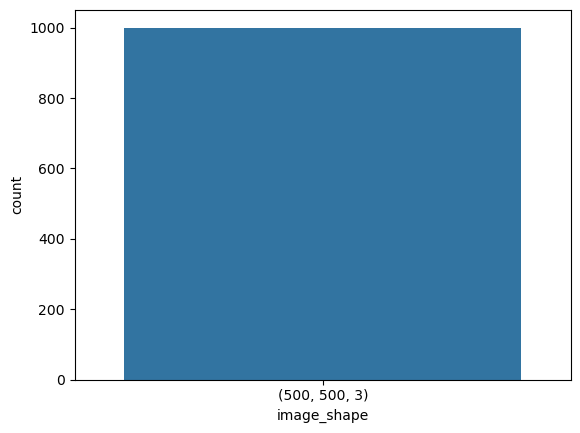

In [127]:
# Compter les occurrences des formats
X_img_sample['image_shape'] = X_img_sample['image_shape'].astype(str)
sns.countplot(data=X_img_sample, x='image_shape', order=X_img_sample['image_shape'].value_counts().index)
plt.show()

On a bien uniquement des images en 500x500 pixels et en RGB.

### Content Box: la zone utile sans les bords blancs

Déterminons maintenant la "zone utile", c'est-à-dire l'image sans les bords blancs.

In [128]:
def get_content_box(image_path, seuil_ratio=0.99):
    """
    Détecte la bounding box du contenu non blanc d'une image.

    Args:
        image_path (str): chemin vers l'image.
        seuil (float): seuil pour considérer un pixel blanc (entre 0 et 1).
    Returns:
        tuple: dimensions de la zone utile (largeur, hauteur), coordonnées x_min, y_min, x_max, y_max.
    """
     
    # Charge l'image (forme: H x W x C), valeurs normalisées [0, 1]
    img = mpimg.imread(image_path)

    # img peut être chargé normalisé (valeurs de couleurs entre 0 et 1) ou en [0, 255]
    # On adapte donc le seuil en fonction de la valeur maximale des pixels
    seuil = seuil_ratio * img.max()

    # Crée un masque des pixels "non blancs"
    # Ici, on considère qu'un pixel est blanc si ses 3 canaux sont > seuil (proche de 1)
    non_white = np.any(img < seuil, axis=2)
   
    # Trouve les coordonnées de la zone utile
    coords = np.argwhere(non_white)

    if coords.size == 0:
        # "Image entièrement blanche."
        return None

    # Récupère les limites du contenu utile
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    width = x_max - x_min + 1
    height = y_max - y_min + 1

    # print(f"Taille utile : {width} x {height} pixels")
    # print(f"Bounding box : x={x_min}, y={y_min}, largeur={width}, hauteur={height}")

    return ((width, height), x_min, y_min, x_max, y_max)

Image dimensions: 500x500 pixels


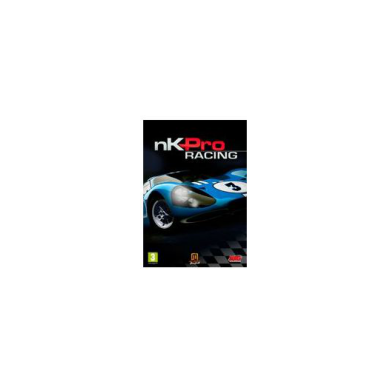

(144, 208) 176 144 319 351


In [129]:
# Exemple d’utilisation
display_image(X_img_sample.iloc[0]["image_path"], print_dim=True)
dim, x_min, y_min, x_max, y_max = get_content_box(image_path=X_img_sample.iloc[0]["image_path"])
print(dim, x_min, y_min, x_max, y_max)

In [130]:
# Charge l'image complète et retourne l'image utile à partir de la bounding box
def load_content_from_box(image_path, x_min, y_min, x_max, y_max):
    # Charge l'image complète
    img = mpimg.imread(image_path)

    # Attention : dans numpy, l'ordre est img[hauteur, largeur] donc img[y_min:y_max+1, x_min:x_max+1]
    img_cropped = img[y_min:y_max+1, x_min:x_max+1, :]
    return img_cropped


def load_content_box_from_image(image_path):
    """
    Charge l'image complète et retourne l'image utile.
    
    Args:
        image_path (str): chemin vers l'image.
    
    Returns:
        np.ndarray: image utile sans les bords blancs.
    """
    dim, x_min, y_min, x_max, y_max = get_content_box(image_path)
    if dim is None:
        return None  # Image entièrement blanche
    
    return load_content_from_box(image_path, x_min, y_min, x_max, y_max)

Image dimensions: 208x144 pixels


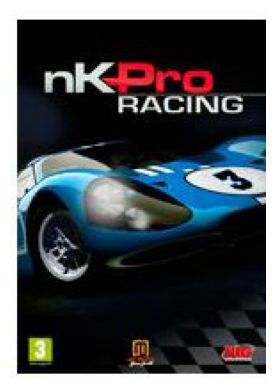

In [131]:
# Exemple d'utilisation
display_image(load_content_box_from_image(X_img_sample.iloc[0]["image_path"]), print_dim=True)

Remplissons notre Dataframe d'échantillon d'images avec ces informations.

In [132]:
df_content_box = X_img_sample["image_path"].apply(get_content_box).apply(pd.Series)
df_content_box.columns = ["content_dim", "x_min", "y_min", "x_max", "y_max"]

X_img_sample["content_dim"] = df_content_box["content_dim"]
X_img_sample[["content_width", "content_height"]] = X_img_sample["content_dim"].apply(pd.Series)
X_img_sample[["x_min", "y_min", "x_max", "y_max"]] = df_content_box[["x_min", "y_min", "x_max", "y_max"]]

In [133]:
data_info(X_img_sample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 36138 to 65534
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_path      1000 non-null   object
 1   image_shape     1000 non-null   object
 2   content_dim     1000 non-null   object
 3   content_width   1000 non-null   int64 
 4   content_height  1000 non-null   int64 
 5   x_min           1000 non-null   int64 
 6   y_min           1000 non-null   int64 
 7   x_max           1000 non-null   int64 
 8   y_max           1000 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 110.4+ KB




image_path    image_shape  \
36138  ./../data/images/image_train/image_1100082580_...  (500, 500, 3)   
68630  ./../data/images/image_train/image_1139624392_...  (500, 500, 3)   
36172  ./../data/images/image_train/image_1271697301_...  (500, 500, 3)   
9830   ./../data/images/image_train/image_1313204688_...  (500, 500, 3)   
28422  ./../data/images/image_train/image_518749844_p...  (500, 500, 3)   

      content_dim  content_width  content_height  x_min  y_min  x_max  y_max  
36138  (144, 208)            144             208    176    144    319    351  
68630  (193, 208)            193             208    176    144    368    351  
36172  (500, 500)            500             500      0      0    499    499  
9830   (395, 500)            395             500     53      0    447    499  
28422  (368, 500)            368             500     64      0    431    499

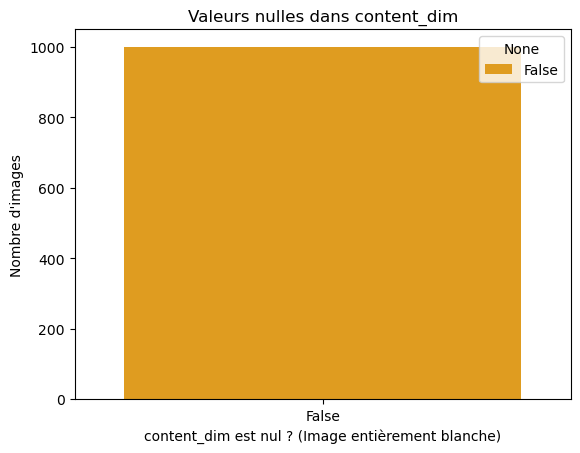

In [134]:
content_dim_value_counts = X_img_sample["content_dim"].isnull().value_counts()
sns.barplot(
    x=content_dim_value_counts.index,
    hue=content_dim_value_counts.index,
    y=content_dim_value_counts.values,
    palette={True: "blue", False: "orange"}
)
plt.title("Valeurs nulles dans content_dim")
plt.xlabel("content_dim est nul ? (Image entièrement blanche)")
plt.ylabel("Nombre d'images")
plt.show()

Quand une image est entièrement blanche, alors le content_dim est nul. Ce n'est pas le cas ici alors aucune de nos images (donc des images liées aux produits) n'est "nulle".

Il ne s'agit que d'un échantillon, même s'il a été choisi aléatoirement, cela ne nous donne pas la proportion totale, mais cela nous sert simplement d'idée. On supposera ainsi qu'aucune image n'est entièrement blanche.

### Uniformité des données d'image et préparation

On s'intéresse aux dimensions de la content box.

False    525
True     475
dtype: int64


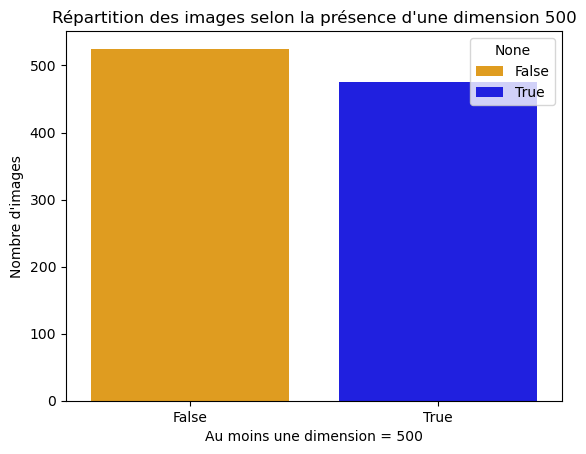

In [135]:
# On considère qu'une image est "complète" si au moins une de ses dimensions (largeur ou hauteur) est égale à 500 pixels.
# Création d'une colonne booléenne "image_complete" : True si width ou height = 500
image_complete = (X_img_sample['content_width'] == 500) | (X_img_sample['content_height'] == 500)
print(image_complete.value_counts())
# Countplot
sns.countplot(x=image_complete, hue=image_complete, palette={True: "blue", False: "orange"})

plt.xlabel("Au moins une dimension = 500")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images selon la présence d'une dimension 500")
plt.show()

On constate que 47,5% n'a aucune de ses dimensions égale à 500. Beaucoup d'images n'occupent donc pas l'espace disponible, dans aucune des dimensions: nous pourrions donc les étendre.

En effet, la zone utile (qui serait également la zone utile pour l'apprentissage par un modèle) est bien différente selon les images.
Nous pourrions alors nous intéresser à appliquer des algorithmes de Computer Vision pour combler cette différence et harmoniser les données et les vecteurs qui en résulteraient.
L'exemple le plus simple serait d'utiliser un filtre avec des masques pour agrandir les images jusqu'à atteindre un des bords.

Il serait plus difficile pour un modèle s'entraînant sur des images d'être pertinent si certaines données sont des matrices creuses (pleine de blanc) et d'autres sont pleines.

Par exemple, deux piscines prenant toute l'image auraient plus d'informations communes dans leurs pixels qu'une piscine en grand, et une piscine en toute petite (majorité de pixels blancs).

Nous aurions pu également visualiser l'ensemble des différents format de Content box mais cela serait bien trop éparpillé et le traitement final serait identique.

# Récapitulatif de l'analyse exploratoire des données initiales

|        | Nombre lignes dans la table : ? | 84916                                                                                                             | Pour le dataset utilisable                                                                                                                       |                                                                                                                      |            |                                                                                                                                                                                                                                           |                                                                                                                                                                                                      |                                                                                  |
|--------|---------------------------------|-------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| N° Col | Nom de la colonne               | Description                                                                                                       | Disponibilité de la variable a priori                                                                                                            | Type informatique                                                                                                    | Taux de NA | Gestion des NA                                                                                                                                                                                                                            | Distribution des valeurs                                                                                                                                                                             | Remarques sur la colonne                                                         |
|        |                                 | Que représente cette variable en quelques mots ?                                                                  | Pouvez vous connaitre ce champ en amont d'une prédiction ? Aurez vous accès à cette variable en environnement de production ?                    | int64, float etc...  Si "object", détaillez.                                                                         | en %       | Quelle mode de (non) - gestion des NA favorisez vous ?                                                                                                                                                                                    | Pour les variables catégorielles comportant moins de 10 catégories, énumérez toutes les catégories.  Pour les variables quantitatives, détaillez la distribution (statistiques descriptives de base) | champs libre à renseigner                                                        |
| 1      | Désignation                     | L’appelation du produit : comme une petite description qui donne l’essentiel sur le produit et donc sa catégorie. | Cette donnée est la base textuelle et est toujours accessible pour la prédiction même en environnement de production.                            | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 0,00 %     | /                                                                                                                                                                                                                                         | C’est un string qui n’est ni quantitatif ni catégoriel. C’est une variable descriptive.                                                                                                              | Les valeurs d’un tel string sont très vastes et une analyse NLP sera nécessaire. |
| 2      | Description                     | Description plus détaillé du produit, de son état, de son utilisation. Regorge d’informations et de mots clés.    | Cette donnée est accessible pour la prédiction même en environnement de production, seulement quand elle n’est pas n/a (nombreuses occurrences). | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 35.09%     | Il s’agit d’une description textuelle : on ne peut la générer pertinemment ni effectuer un remplissage statistique. Soit on l’utilise seulement lorsqu’elle est présente ; soit on fait un remplissage par IA à partir de la désignation. | Identique à la désignation à l’exception des nombreux N/A.                                                                                                                                           | Identique à la désignation.                                                      |
| 3      | productid                       | L’index du produit                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 4      | imageid                         | L’index de l’image                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 5      | imagepath                       | Le path de l’image pour l’associer au produit                                                                     | Utile en prod pour entraîner sur l’image tout en ayant la bonne évaluation de la classe                                                          | string                                                                                                               | 0.00%      | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |

# Stratégie envisagée suite à l'exploration des données

Première idée de stratégie:

- Diviser X_train en deux DataFrames : un pour l'entraînement, l'autre pour le test.
- Faire de même pour y_train avec la même répartition.
- Définir si nous décidons de remplir les descriptions nulles par des descriptions générées (identique à la désignation ? mot clé de la désignation ?) ou non.
- Créer un modèle pour classer les produits à partir du texte, incluant du traitement du langage naturel (NLP) sur la désignation et la description de chaque produit.
- Appliquer des algorithmes de Computer Vision pour harmoniser le dataset d'images.
- Transformer les images en vecteurs, associés aux produits, pour créer un DataFrame de pixels.
- Créer un modèle pour classer les produits à partir des images.
- Évaluer les deux modèles.
- Les ajuster ou les améliorer.
- Définir des pondérations pour les deux modèles en fonction de leurs performances.
- Créer une fonction pour obtenir une moyenne pondérée des probabilités pour les meilleures classes. (Comme pour du Bagging)
- Évaluer les résultats en sélectionnant la meilleure classe selon cette moyenne pondérée lors d'une phase de test.
- Tenter d'améliorer les résultats en travaillant sur les pondérations.
- Comparer les performances de ces résultats avec celles du meilleur des deux modèles initiaux.
- Conclure sur la solution (le modèle ou la combinaison) qui serait la plus efficace.